In [86]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping

# Cargar los datos
df = pd.read_csv('../datos_simulados/datos_final.csv')

# Crear la columna objetivo
df['Resina_utilizada'] = df['Peso_resina_inicial_mg'] - df['Peso_sobrante_mg']

In [87]:
# Crear la columna objetivo
df['Resina_utilizada'] = df['Peso_resina_inicial_mg'] - df['Peso_sobrante_mg']

# Variables categóricas importantes
columnas_categoricas = ['Pieza', 'Superficie_1', 'Superficie_2']

# Variables numéricas relevantes
columnas_numericas = ['Tamanio_cavidad_mm', 'Indice_contraccion_%', 'Margen_cavo_mm']

# Codificar variables categóricas
df_codificado = pd.get_dummies(df[columnas_categoricas + columnas_numericas])

# Definir X (entradas) e y (salida)
X = df_codificado
y = df['Resina_utilizada']

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [88]:
# Normalizar características con StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [89]:
# Crear el modelo secuencial
modelo_mlp = Sequential()
modelo_mlp.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
modelo_mlp.add(Dense(64, activation='relu'))
modelo_mlp.add(Dense(32, activation='relu'))
modelo_mlp.add(Dense(1))  # salida continua (regresión)

C:\Users\mau_a\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [90]:
# EarlyStopping para evitar overfitting
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

# Compilar el modelo
modelo_mlp.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Entrenar el modelo con early stopping
historial = modelo_mlp.fit(
    X_train_scaled, y_train,
    epochs=150,
    batch_size=8,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/150
496/496 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4299.1123 - mae: 56.1335 - val_loss: 336.7059 - val_mae: 15.1107
Epoch 2/150
496/496 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 306.7383 - mae: 14.3869 - val_loss: 321.0020 - val_mae: 14.7673
Epoch 3/150
496/496 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 306.0765 - mae: 14.4181 - val_loss: 319.7521 - val_mae: 14.6640
Epoch 4/150
496/496 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 310.9122 - mae: 14.5652 - val_loss: 319.2124 - val_mae: 14.6855
Epoch 5/150
496/496 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 302.9658 - mae: 14.3737 - val_loss: 315.4223 - val_mae: 14.5935
Epoch 6/150
496/496 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 300.0214 - mae: 14.3691 - val_loss: 317.3506 - val_mae: 14.6448
Epoch 7/150
496/496 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 301.2327 - mae: 14.3810 - val_loss: 314.0426 - val_mae: 14.6004
Epoch 8/150
496/496 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 304.6935 - mae: 14.4567 - val_loss: 311.2899 - val_mae: 14.4760

In [91]:
# Evaluar el modelo en el conjunto de prueba
test_mse, test_mae = modelo_mlp.evaluate(X_test_scaled, y_test, verbose=0)
print(f"MAE en prueba: {test_mae:.2f}")
print(f"MSE en prueba: {test_mse:.2f}")

MAE en prueba: 14.43
MSE en prueba: 303.67


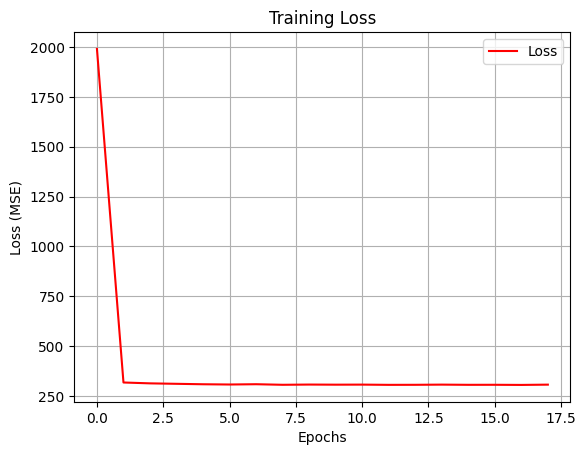

In [92]:
# Recuperar la pérdida por época durante el entrenamiento
train_loss_history = historial.history['loss']
epochs = range(len(train_loss_history))

# Gráfica general de pérdida
plt.plot(epochs, train_loss_history, 'r')
plt.title('Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend(["Loss"])
plt.grid(True)
plt.show()

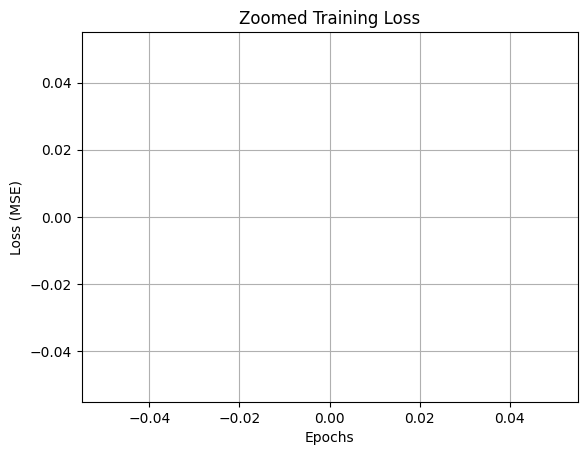

In [93]:
# Zoom a partir de la época 20
zoomed_loss = train_loss_history[20:]
zoomed_epochs = range(20, len(train_loss_history))

plt.plot(zoomed_epochs, zoomed_loss)
plt.title("Zoomed Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.grid(True)
plt.show()

In [94]:
# Hacer predicciones sobre el conjunto de prueba
y_pred = modelo_mlp.predict(X_test_scaled)

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calcular R²
r2 = r2_score(y_test, y_pred)

# Mostrar resultados
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RMSE: 17.43
R²: 0.26
